<a href="https://colab.research.google.com/github/ZeeTsing/Carvana_challenge/blob/master/Naive_CNN_Carvana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep: Download data from Kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zeetsing","key":"d4e13cfa3a5b2638778ed81f8ef820b2"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! unzip train_masks.csv.zip -d /content/drive/My\ Drive/car_data

Archive:  train_masks.csv.zip
  inflating: /content/drive/My Drive/car_data/train_masks.csv  


# Prep: transform image size & normalized images prep data for training

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
import os
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
input_folder = '/content/drive/My Drive/car_data'

df_mask = pd.read_csv(join(input_folder, 'train_masks.csv'), usecols=['img'])
ids_train = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

imgs_idx = list(range(1, 17))

In [0]:
img_dim1 = 1280
img_dim2 = 1918
resize_factor = 1
resize_dim1 = round(img_dim1 / resize_factor)
resize_dim2 = round(img_dim2 / resize_factor)

In [0]:
load_img = lambda im, idx: imread(join(input_folder, 'train', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join(input_folder, 'train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))
resize = lambda im: downscale_local_mean(im, (resize_factor,resize_factor) if im.ndim==2 else (resize_factor,resize_factor,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))

In [7]:
num_train = 135 #len(ids_train)

# Load data for position id=1
X = np.empty((num_train, resize_dim1, resize_dim2, 9), dtype=np.float32) # 9 channels because there are 3 images superimposed
y = np.empty((num_train, resize_dim1, resize_dim2, 1), dtype=np.float32)

with tqdm(total=num_train) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        if resize_factor == 1:
          imgs_id = [load_img(img_id, j) for j in imgs_idx]
        else:
          imgs_id = [resize(load_img(img_id, j)) for j in imgs_idx]
        # Input is image + mean image per channel + std image per channel
        X[i, ..., :9] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
        y[i] = resize(np.expand_dims(load_mask(img_id, idx), 2)) / 255.
        #del imgs_id # Free memory
        bar.update()

In [0]:
# Normalize input and output
X_mean = X.mean(axis=(0,1,2), keepdims=True)
X_std = X.std(axis=(0,1,2), keepdims=True)

X -= X_mean
X /= X_std

# Set up Naive CNN model, fit and train

In [0]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
from tensorflow.keras.backend import flatten
import tensorflow.keras.backend as K
from tensorflow.keras.losses import BinaryCrossentropy

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential


model = Sequential()
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(resize_dim1, resize_dim2, 9)) )
model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( Conv2D(1, 5, activation='sigmoid', padding='same') )

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = adam, loss = BinaryCrossentropy(), metrics=['accuracy',dice_coef])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1280, 1918, 16)    1312      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1280, 1918, 32)    4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1280, 1918, 1)     801       
Total params: 6,753
Trainable params: 6,753
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/My Drive/car_data/naivecp/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

#create early stop condition where validation dice_coef plataued for 10 epochs the algo will stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=10)

# reduce learning rate if the dice_coef hitting platau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef',
                                   factor=0.2,
                                   patience=5,
                                   verbose=1,
                                   min_delta=1e-4,
                                   mode='max')

In [13]:
model.fit(X, y, epochs=50, validation_split=0.2,callbacks=[cp_callback,early_stop,reduce_lr], batch_size=5, verbose=2)

Train on 108 samples, validate on 27 samples
Epoch 1/50

Epoch 00001: saving model to /content/drive/My Drive/car_data/naivecp/cp-0001.ckpt
108/108 - 26s - loss: 0.6699 - accuracy: 0.5743 - dice_coef: 0.2438 - val_loss: 0.4470 - val_accuracy: 0.8380 - val_dice_coef: 0.2815
Epoch 2/50

Epoch 00002: saving model to /content/drive/My Drive/car_data/naivecp/cp-0002.ckpt
108/108 - 13s - loss: 0.3637 - accuracy: 0.8580 - dice_coef: 0.3134 - val_loss: 0.3183 - val_accuracy: 0.8699 - val_dice_coef: 0.3771
Epoch 3/50

Epoch 00003: saving model to /content/drive/My Drive/car_data/naivecp/cp-0003.ckpt
108/108 - 13s - loss: 0.2915 - accuracy: 0.8730 - dice_coef: 0.4108 - val_loss: 0.2933 - val_accuracy: 0.8546 - val_dice_coef: 0.4453
Epoch 4/50

Epoch 00004: saving model to /content/drive/My Drive/car_data/naivecp/cp-0004.ckpt
108/108 - 13s - loss: 0.2766 - accuracy: 0.8734 - dice_coef: 0.4505 - val_loss: 0.2874 - val_accuracy: 0.8538 - val_dice_coef: 0.4716
Epoch 5/50

Epoch 00005: saving model t

# Results

Text(0, 0.5, 'Loss')

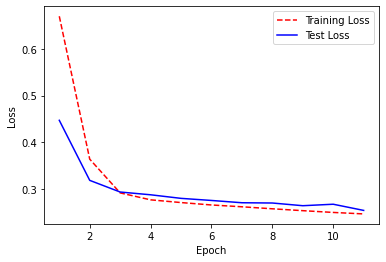

In [14]:
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

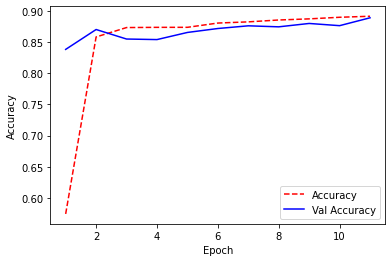

In [15]:
training_loss = model.history.history['accuracy']
test_loss = model.history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Dice Coef')

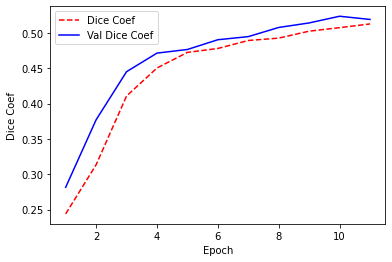

In [16]:
training_loss = model.history.history['dice_coef']
test_loss = model.history.history['val_dice_coef']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Dice Coef', 'Val Dice Coef'])
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')

In [0]:
save_path = '/content/drive/My Drive/car_data/model2/'

In [18]:
tf.keras.models.save_model(model,save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/car_data/model2/assets


In [0]:
from google.colab import drive
drive.flush_and_unmount()